In [15]:
import networkx as nx
import matplotlib.pyplot as plt


In [16]:
# Define the network
G = nx.DiGraph()

# Add nodes
graph_nodes = ['o', 'a', 'b', 'c', 'd']
G.add_nodes_from(graph_nodes)

# Add edges with capacities
edges_with_capacities = [
    ('o', 'a', 3),
    ('o', 'b', 3),
    ('a', 'b', 1),
    ('a', 'd', 2),
    ('b', 'c', 3),
    ('b', 'd', 2),
    ('c', 'd', 1),
]
G.add_weighted_edges_from(edges_with_capacities, weight='capacity')

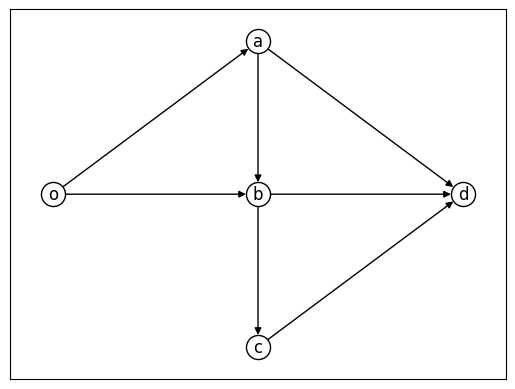

In [17]:
position = {
    'o': (-1, 0),
    'a': (0, 1),
    'b': (0, 0),
    'c': (0, -1),
    'd': (1, 0)
}


nx.draw_networkx(G, with_labels=True, pos=position ,node_color='white',edgecolors='black')
plt.show()


**Part 1.a**: Compute the capacities of all cuts and find the minimum cut

In [18]:
min_cut_value, partition = nx.minimum_cut(G, 'o', 'd', capacity='capacity')
print(f"Minimum cut value: {min_cut_value}")
print(f"Partition: {partition}")


Minimum cut value: 5
Partition: ({'a', 'c', 'o', 'b'}, {'d'})


**Part 1.b**: Distribute x extra units of capacity to maximize throughput

In [19]:
def update_graph_capacities(graph, updated_capacities):
    """
    Update the capacities of edges in the graph.

    Parameters:
        graph (networkx.DiGraph): The directed graph.
        updated_capacities (dict): A dictionary with edge tuples as keys and new capacities as values.

    Returns:
        None: Updates the graph in place.
    """
    for (u, v), new_capacity in updated_capacities.items():
        if graph.has_edge(u, v):
            graph[u][v]['capacity'] = new_capacity 

In [20]:
def distribute_capacity_bottleneck_strategy(G:nx.DiGraph, x):
    """
    Distribute extra capacity among bottleneck edges and return the new minimum cut value.

    Parameters:
        graph (networkx.DiGraph): The directed graph.
        x (int): Extra capacity to distribute.

    Returns:
        float: New minimum cut value after updating capacities.
    """
    # Find the minimum cut
    graph = G.copy()
    min_cut_value, partition = nx.minimum_cut(graph, 'o', 'd', capacity='capacity')
    left_set, right_set = partition

    # Find edges crossing the cut (bottleneck edges)
    cut_edges = []
    for u, v, data in graph.edges(data=True):
        if u in left_set and v in right_set:
            cut_edges.append((u, v, data['capacity']))  # Use 'capacity' for capacity

    # Total capacity of bottleneck edges
    total_capacity = sum(edge[2] for edge in cut_edges)

    # Distribute x proportionally among bottleneck edges
    distributed_capacities = {}
    for u, v, capacity in cut_edges:
        distributed_capacities[(u, v)] = capacity + x * (capacity / total_capacity)

    # Update graph capacities
    update_graph_capacities(graph, distributed_capacities)
    
    # Recompute the minimum cut and return the new cut value
    new_min_cut_value, _ = nx.minimum_cut(graph, 'o', 'd', capacity='capacity')

    return int(new_min_cut_value)



In [21]:
def distribute_capacity_critical_path_strategy(G: nx.DiGraph, x: int) -> float:
    """
    Distribute extra capacity among the most critical edges to maximize throughput.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        x (int): Extra capacity to distribute.

    Returns:
        float: The new maximum flow value after capacity allocation.
    """
    # Make a copy of the graph to avoid modifying the original
    graph = G.copy()

    while x > 0:
        # Step 1: Compute current maximum flow and flow distribution
        flow_value, flow_dict = nx.maximum_flow(graph, 'o', 'd', capacity='capacity')
        
        # Step 2: Identify saturated edges (flow == capacity)
        saturated_edges = []
        for u, v, data in graph.edges(data=True):
            capacity = data.get('capacity', 0)
            flow = flow_dict[u][v]
            if flow == capacity:  # Bottleneck edge
                saturated_edges.append((u, v, capacity))
        
        # If no saturated edges, stop the allocation
        if not saturated_edges:
            break

        # Step 3: Allocate extra capacity to saturated edges
        for u, v, capacity in saturated_edges:
            if x <= 0:
                break
            # Allocate 1 unit of capacity to the edge
            graph[u][v]['capacity'] += 1
            x -= 1

    # Step 4: Recompute the maximum flow after allocation
    new_flow_value, _ = nx.maximum_flow(graph, 'o', 'd', capacity='capacity')
    return new_flow_value

In [22]:
bottleneck = []
criticals = []
X = 10



for x in range(X+1):
    throughput = distribute_capacity_bottleneck_strategy(G, x)
    bottleneck.append(throughput)

for x in range(X+1):
    throughput = distribute_capacity_critical_path_strategy(G, x)
    criticals.append(throughput)



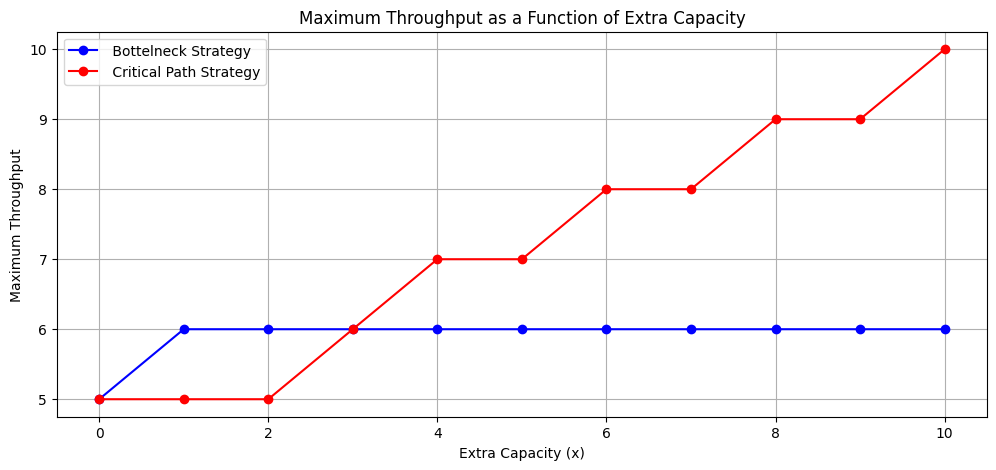

In [23]:
# Plot the throughput as a function of x
plt.figure(figsize=(12,5))
plt.plot(range(X+1), bottleneck, marker='o', label=' Bottelneck Strategy', color='blue')
plt.plot(range(X+1), criticals, marker='o', label=' Critical Path Strategy', color='red')

plt.title("Maximum Throughput as a Function of Extra Capacity")
plt.xlabel("Extra Capacity (x)")
plt.ylabel("Maximum Throughput")
plt.grid()
plt.legend()
plt.savefig('comparison_plot.jpg')
plt.show()

**Part 1.c:** add an edge between o and d then distribute x extra units of capacity to maximize throughput

In [24]:
def find_best_placement_for_e8(G: nx.DiGraph) -> tuple:
    """
    Find the best placement for edge e8 to maximize throughput.

    Parameters:
        G (networkx.DiGraph): The directed graph.

    Returns:
        tuple: The best placement for e8 and the maximum throughput achieved.
    """
    
    nodes = list(G.nodes)
    best_throughput = 0
    best_placement = None

    # Iterate over all possible node pairs where there is no existing edge
    for u in nodes:
        for v in nodes:
            if u != v and not G.has_edge(u, v):
                # Temporarily add e8
                temp_G = G.copy()
                temp_G.add_edge(u, v, capacity=1)

                # Compute max flow
                flow_value, _ = nx.maximum_flow(temp_G, 'o', 'd', capacity='capacity')

                # Update best placement if the current placement improves throughput
                if flow_value > best_throughput:
                    best_throughput = flow_value
                    best_placement = (u, v)

    return best_placement, best_throughput



In [25]:
# Example Usage
best_placement, best_throughput = find_best_placement_for_e8(G)
print(f"Best placement for e8: {best_placement} with throughput: {best_throughput}")

G_e8 = G.copy()
# Add e8 to the graph at the best placement
G_e8.add_edge(best_placement[0], best_placement[1], capacity=1)

Best placement for e8: ('o', 'd') with throughput: 6


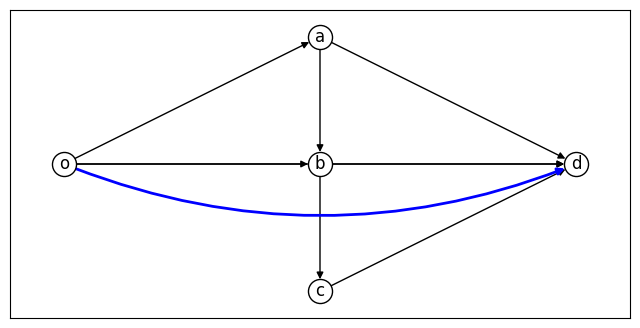

In [26]:

plt.figure(figsize=(8, 4))
nx.draw_networkx(G_e8, with_labels=True, pos=position, node_color='white', edgecolors='black',)

# Add curved edge separately using Bezier curves
nx.draw_networkx_edges(
    G_e8,
    pos=position,
    edgelist=[('o', 'd')],
    edge_color='blue',
    width=2, 
    connectionstyle="arc3,rad=0.2"
)

plt.savefig("G_with_e8.jpg")
plt.show()

In [27]:
bottleneck = []
criticals = []
X = 10



for x in range(X+1):
    throughput = distribute_capacity_bottleneck_strategy(G_e8, x)
    bottleneck.append(throughput)

for x in range(X+1):
    throughput = distribute_capacity_critical_path_strategy(G_e8, x)
    criticals.append(throughput)



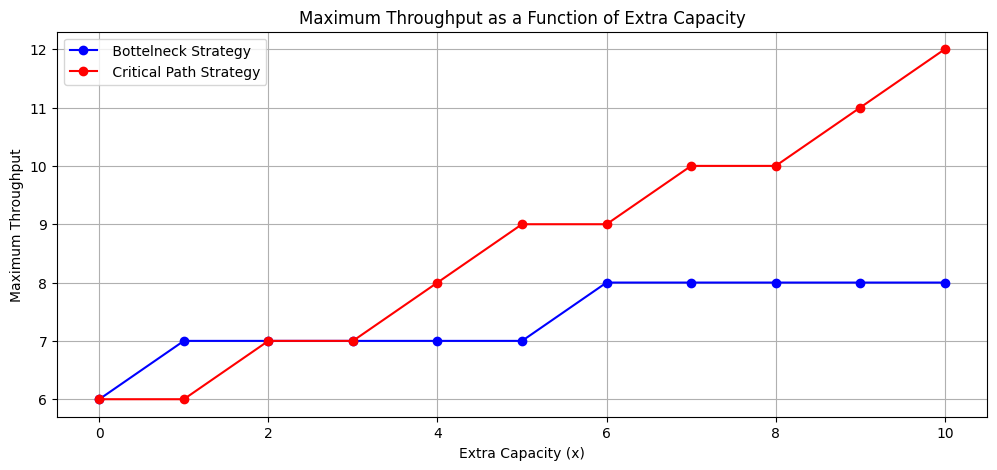

In [28]:


# Plot the throughput as a function of x
plt.figure(figsize=(12,5))
plt.plot(range(X+1), bottleneck, marker='o', label=' Bottelneck Strategy', color='blue')
plt.plot(range(X+1), criticals, marker='o', label=' Critical Path Strategy', color='red')

plt.title("Maximum Throughput as a Function of Extra Capacity")
plt.xlabel("Extra Capacity (x)")
plt.ylabel("Maximum Throughput")
plt.grid()
plt.legend()
plt.savefig('comparison_plot_e8.jpg')
plt.show()